In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple, Union
from dataclasses import dataclass

EPS = 1e-12

@dataclass
class SphereOverlap:
    """Represents overlap between two spheres with reflection and transmission coefficients."""
    idx_A: int
    idx_B: int
    reflection_coeff: float
    transmission_coeff: float

class WaveSphere:
    """Represents a single wave sphere with fast and slow dynamics."""
    
    def __init__(self, fast_alpha: float = 0.9, slow_alpha: float = 0.1, noise_std: float = 0.0):
        self.fast_alpha = fast_alpha
        self.slow_alpha = slow_alpha
        self.noise_std = noise_std
        self.reset()
    
    def reset(self) -> None:
        """Reset sphere states to initial configuration."""
        self.fast_state = np.array([1.0, 0.0, 0.0, 0.0])
        self.slow_state = np.array([1.0, 0.0, 0.0, 0.0])
    
    @staticmethod
    def normalize_sphere_4d(vec: np.ndarray) -> np.ndarray:
        """Normalize a 4D vector to unit length."""
        norm = np.linalg.norm(vec)
        return np.array([1.0, 0.0, 0.0, 0.0]) if norm < EPS else vec / norm
    
    @staticmethod
    def partial_interference_sphere(base: np.ndarray, new: np.ndarray, alpha: float = 1.0) -> np.ndarray:
        """Compute partial interference between two sphere states."""
        p_n = WaveSphere.normalize_sphere_4d(base)
        q_n = WaveSphere.normalize_sphere_4d(new)
        dot_ = np.clip(np.dot(p_n, q_n), -1.0, 1.0)
        angle = np.arccos(dot_)
        
        if angle < EPS:
            return p_n
            
        perp = q_n - dot_ * p_n
        perp_norm = np.linalg.norm(perp)
        
        if perp_norm < EPS:
            return p_n
            
        dir_ = perp / perp_norm
        v_scaled = alpha * angle * dir_
        
        norm_v = np.linalg.norm(v_scaled)
        if norm_v < EPS:
            return p_n
            
        new_point = np.cos(norm_v) * p_n + np.sin(norm_v) * (v_scaled / norm_v)
        return WaveSphere.normalize_sphere_4d(new_point)
    
    def inject_random_spike(self, amplitude: float = 1.0) -> None:
        """Inject random noise into the fast state."""
        if self.noise_std >= EPS:
            rnd = np.random.randn(4) * self.noise_std * amplitude
            spike_target = self.normalize_sphere_4d(rnd)
            self.fast_state = self.partial_interference_sphere(self.fast_state, spike_target, alpha=0.5)
    
    def update_with_input(self, input_wave: np.ndarray, gating: bool = True) -> None:
        """Update sphere states with input wave."""
        if gating:
            self.fast_state = self.partial_interference_sphere(self.fast_state, input_wave, alpha=self.fast_alpha)
            self.slow_state = self.partial_interference_sphere(self.slow_state, input_wave, alpha=self.slow_alpha)
    
    def combine_states(self) -> np.ndarray:
        """Combine fast and slow states."""
        return self.partial_interference_sphere(self.fast_state, self.slow_state, alpha=0.5)

class MultiSphereWaveModel:
    """Multi-sphere wave memory model with overlapping spheres."""
    
    def __init__(self, M: int = 3, reflection: float = 0.2, transmission: float = 0.7, noise_std: float = 0.0):
        self.M = M
        self.spheres = [WaveSphere(fast_alpha=0.8, slow_alpha=0.2, noise_std=noise_std) for _ in range(M)]
        # Chain-only overlaps:
        self.overlaps = [
            SphereOverlap(i, i+1, reflection, transmission)
            for i in range(M-1)
        ]
        
    def set_initial_state(self, idx: int, fast_vec: List[float], slow_vec: Optional[List[float]] = None) -> None:
        """Set initial state for a specific sphere."""
        self.spheres[idx].fast_state = WaveSphere.normalize_sphere_4d(np.array(fast_vec))
        if slow_vec is not None:
            self.spheres[idx].slow_state = WaveSphere.normalize_sphere_4d(np.array(slow_vec))
            
    def _process_boundary_interactions(self, new_fast: List[np.ndarray], new_slow: List[np.ndarray]) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """Process boundary interactions between spheres."""
        for overlap in self.overlaps:
            iA, iB = overlap.idx_A, overlap.idx_B
            r_coef, t_coef = overlap.reflection_coeff, overlap.transmission_coeff
            
            # Calculate interference scales
            dotF = np.dot(new_fast[iA], new_fast[iB])
            dotS = np.dot(new_slow[iA], new_slow[iB])
            
            scaleF = 1.0 - 0.5 * abs(dotF) if dotF < 0 else 1.0 + 0.2 * dotF
            scaleS = 1.0 - 0.5 * abs(dotS) if dotS < 0 else 1.0 + 0.2 * dotS
            
            # Calculate alphas
            alphas = {
                'fr': np.clip(r_coef * scaleF, 0, 1),
                'ft': np.clip(t_coef * scaleF, 0, 1),
                'sr': np.clip(r_coef * scaleS, 0, 1),
                'st': np.clip(t_coef * scaleS, 0, 1)
            }
            
            # Process merges
            merged = {
                'fA': WaveSphere.partial_interference_sphere(new_fast[iA], new_fast[iB], alpha=alphas['fr']),
                'sA': WaveSphere.partial_interference_sphere(new_slow[iA], new_slow[iB], alpha=alphas['sr']),
                'fB': WaveSphere.partial_interference_sphere(new_fast[iB], new_fast[iA], alpha=alphas['ft']),
                'sB': WaveSphere.partial_interference_sphere(new_slow[iB], new_slow[iA], alpha=alphas['st'])
            }
            
            # Update states
            new_fast[iA] = WaveSphere.partial_interference_sphere(new_fast[iA], merged['fA'], alpha=0.5)
            new_slow[iA] = WaveSphere.partial_interference_sphere(new_slow[iA], merged['sA'], alpha=0.5)
            new_fast[iB] = WaveSphere.partial_interference_sphere(new_fast[iB], merged['fB'], alpha=0.5)
            new_slow[iB] = WaveSphere.partial_interference_sphere(new_slow[iB], merged['sB'], alpha=0.5)
            
        return new_fast, new_slow
    
    def step(self, input_waves: Optional[List[np.ndarray]] = None, gating_flags: Optional[List[bool]] = None) -> List[np.ndarray]:
        """Perform one step of wave propagation."""
        input_waves = input_waves or [None] * self.M
        gating_flags = gating_flags or [True] * self.M
        
        # Inject random spikes and process inputs
        for i, sphere in enumerate(self.spheres):
            sphere.inject_random_spike(amplitude=1.0)
            if input_waves[i] is not None:
                wave_in = WaveSphere.normalize_sphere_4d(input_waves[i])
                sphere.update_with_input(wave_in, gating=gating_flags[i])
        
        # Get current states
        new_fast = [s.fast_state.copy() for s in self.spheres]
        new_slow = [s.slow_state.copy() for s in self.spheres]
        
        # Process boundary interactions
        new_fast, new_slow = self._process_boundary_interactions(new_fast, new_slow)
        
        # Update sphere states
        for i, sphere in enumerate(self.spheres):
            sphere.fast_state = new_fast[i]
            sphere.slow_state = new_slow[i]
        
        # Return combined states
        return [sphere.combine_states() for sphere in self.spheres]
    
    def run(self, steps: int = 10, input_waves_seq: Optional[List[List[np.ndarray]]] = None, 
            gating_seq: Optional[List[List[bool]]] = None) -> np.ndarray:
        """Run the model for multiple steps."""
        input_waves_seq = input_waves_seq or [[None] * self.M for _ in range(steps)]
        gating_seq = gating_seq or [[True] * self.M for _ in range(steps)]
        
        history = []
        for t in range(steps):
            final_outs = self.step(input_waves_seq[t], gating_seq[t])
            history.append(final_outs)
        
        return np.array(history)


Analysis Results:
--------------------------------------------------
Computation Time: 0.0147s
Total Time: 0.0551s
Interference Strength: 0.8733
Energy Stability: 1.0000
Phase Coherence: 0.9656


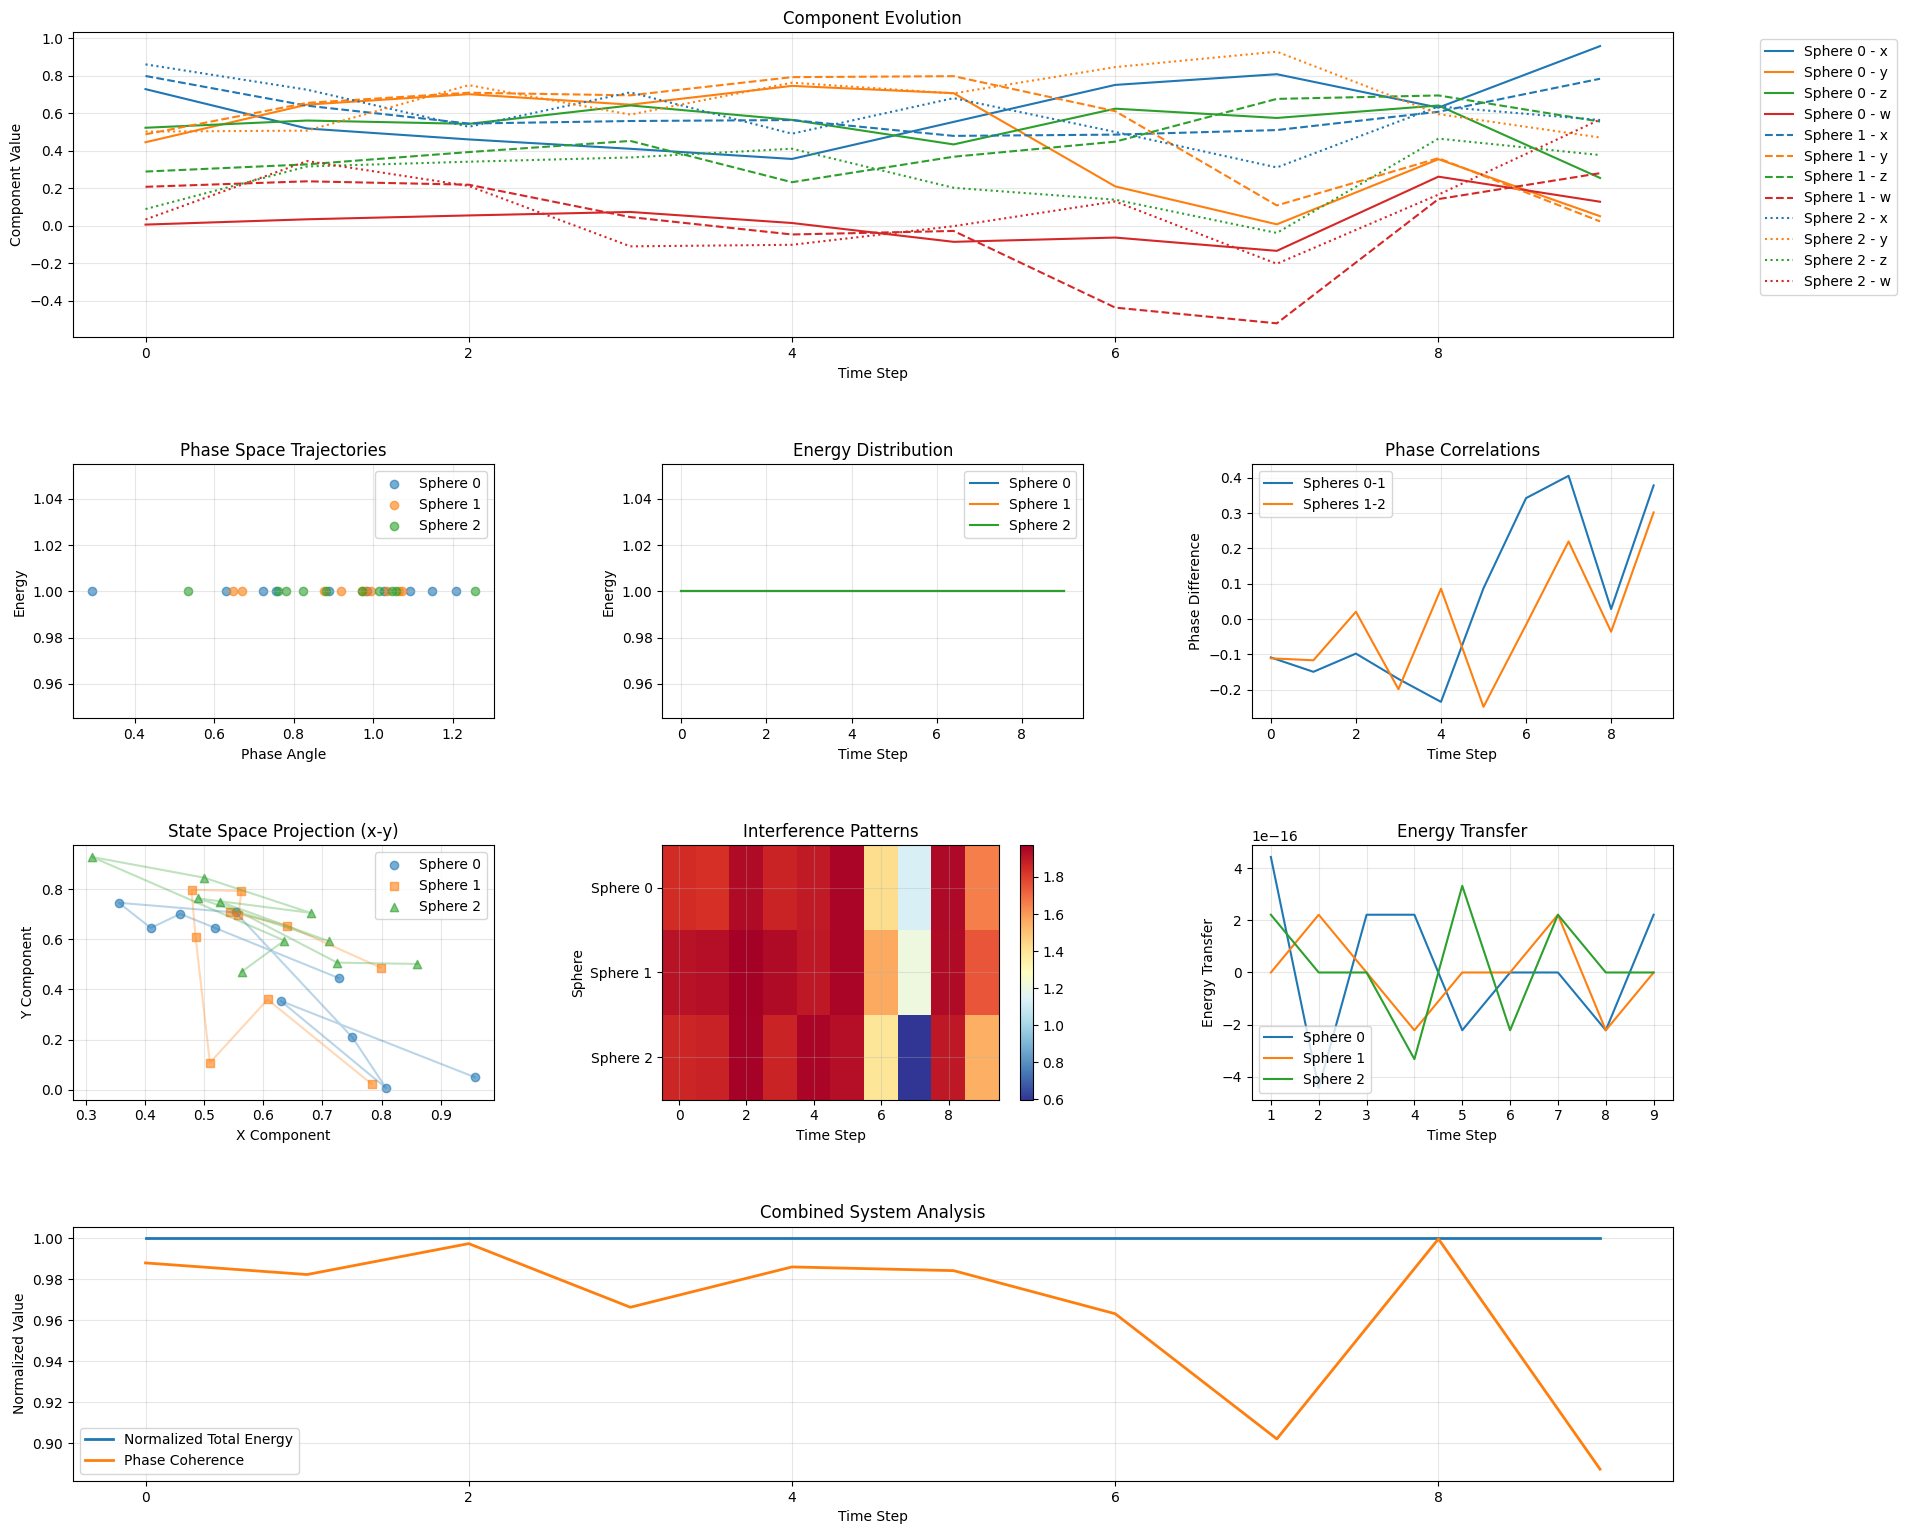

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
from dataclasses import dataclass
from typing import List, Dict, Tuple

@dataclass
class AnalysisMetrics:
    """Metrics for wave memory analysis"""
    computation_time: float
    interference_strength: float
    energy_stability: float
    phase_coherence: float
    total_time: float

class WaveMemoryAnalyzer:
    def __init__(self):
        # Set up matplotlib style
        plt.rcParams['figure.facecolor'] = 'white'
        plt.rcParams['axes.facecolor'] = 'white'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['grid.alpha'] = 0.3
        
    def analyze_model(self, model: MultiSphereWaveModel, steps: int = 10) -> Tuple[plt.Figure, np.ndarray, AnalysisMetrics]:
        """Run complete analysis of wave memory model"""
        start_time = time.perf_counter()
        
        # Run model
        model.set_initial_state(0, fast_vec=[1, 0, 0, 0])
        model.set_initial_state(1, fast_vec=[0.7, 0.7, 0, 0])
        model.set_initial_state(2, fast_vec=[0, 1, 0, 0])
        
        # Setup input sequence
        input_waves_seq = []
        gating_seq = []
        for t in range(steps):
            if t < 5:
                wave_0 = np.array([0.0, 0.5, 0.5, 0.0])
                input_waves_seq.append([wave_0, None, None])
                gating_seq.append([True, False, False])
            else:
                input_waves_seq.append([None, None, None])
                gating_seq.append([False, False, False])
        
        # Time computation
        comp_start = time.perf_counter()
        history = model.run(steps=steps, input_waves_seq=input_waves_seq, gating_seq=gating_seq)
        computation_time = time.perf_counter() - comp_start
        
        # Create visualization
        fig = self.create_visualization(history)
        
        # Calculate metrics
        metrics = AnalysisMetrics(
            computation_time=computation_time,
            interference_strength=self._compute_interference(history),
            energy_stability=self._compute_energy_stability(history),
            phase_coherence=self._compute_phase_coherence(history),
            total_time=time.perf_counter() - start_time
        )
        
        return fig, history, metrics
    
    def create_visualization(self, history: np.ndarray) -> plt.Figure:
        """Create comprehensive visualization of model behavior"""
        fig = plt.figure(figsize=(20, 24))
        gs = GridSpec(6, 3, height_ratios=[1.2, 1, 1, 1, 1, 0.8], hspace=0.5, wspace=0.4)
        
        self._plot_component_evolution(fig.add_subplot(gs[0, :]), history)
        self._plot_phase_space(fig.add_subplot(gs[1, 0]), history)
        self._plot_energy_distribution(fig.add_subplot(gs[1, 1]), history)
        self._plot_phase_correlations(fig.add_subplot(gs[1, 2]), history)
        self._plot_state_space(fig.add_subplot(gs[2, 0]), history)
        self._plot_interference_patterns(fig.add_subplot(gs[2, 1]), history)
        self._plot_energy_transfer(fig.add_subplot(gs[2, 2]), history)
        self._plot_combined_analysis(fig.add_subplot(gs[3, :]), history)
        
        plt.subplots_adjust(top=0.95, bottom=0.05, left=0.1, right=0.9)
        return fig
    
    def _plot_component_evolution(self, ax, history):
        """Plot evolution of wave components"""
        steps = len(history)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        styles = ['-', '--', ':']
        labels = ['x', 'y', 'z', 'w']
        
        for sphere_id in range(history.shape[1]):
            for dim in range(4):
                ax.plot(range(steps), history[:, sphere_id, dim],
                       color=colors[dim],
                       linestyle=styles[sphere_id],
                       label=f'Sphere {sphere_id} - {labels[dim]}')
        
        ax.set_title('Component Evolution')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Component Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    def _plot_phase_space(self, ax, history):
        """Plot phase space trajectories"""
        for sphere_id in range(history.shape[1]):
            phase_angles = [np.arctan2(np.linalg.norm(state[1:]), state[0]) 
                          for state in history[:, sphere_id]]
            energies = [np.sum(state**2) for state in history[:, sphere_id]]
            ax.scatter(phase_angles, energies, label=f'Sphere {sphere_id}', alpha=0.6)
        
        ax.set_title('Phase Space Trajectories')
        ax.set_xlabel('Phase Angle')
        ax.set_ylabel('Energy')
        ax.legend()
    
    def _plot_energy_distribution(self, ax, history):
        """Plot energy distribution over time"""
        steps = len(history)
        for sphere_id in range(history.shape[1]):
            energies = [np.sum(state**2) for state in history[:, sphere_id]]
            ax.plot(range(steps), energies, label=f'Sphere {sphere_id}')
        
        ax.set_title('Energy Distribution')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Energy')
        ax.legend()
    def _plot_phase_correlations(self, ax, history):
        """Plot phase correlations between spheres"""
        steps = len(history)
        for i in range(2):  # For pairs of spheres
            phase_diff = []
            for t in range(steps):
                p1 = np.arctan2(np.linalg.norm(history[t, i, 1:]), history[t, i, 0])
                p2 = np.arctan2(np.linalg.norm(history[t, i+1, 1:]), history[t, i+1, 0])
                phase_diff.append(p2 - p1)
            ax.plot(range(steps), phase_diff, label=f'Spheres {i}-{i+1}')
        
        ax.set_title('Phase Correlations')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Phase Difference')
        ax.legend()
    
    def _plot_state_space(self, ax, history):
        """Plot state space projection"""
        markers = ['o', 's', '^']
        for sphere_id in range(history.shape[1]):
            ax.scatter(history[:, sphere_id, 0], history[:, sphere_id, 1],
                      marker=markers[sphere_id], label=f'Sphere {sphere_id}', alpha=0.6)
            ax.plot(history[:, sphere_id, 0], history[:, sphere_id, 1], alpha=0.3)
        
        ax.set_title('State Space Projection (x-y)')
        ax.set_xlabel('X Component')
        ax.set_ylabel('Y Component')
        ax.legend()
    
    def _plot_interference_patterns(self, ax, history):
        """Plot interference patterns between spheres"""
        steps = len(history)
        interference = np.zeros((steps, history.shape[1]))
        for t in range(steps):
            for i in range(history.shape[1]):
                interference[t, i] = sum(abs(np.dot(history[t, i], history[t, j])) 
                                       for j in range(history.shape[1]) if j != i)
        
        im = ax.imshow(interference.T, aspect='auto', cmap='RdYlBu_r')
        plt.colorbar(im, ax=ax)
        ax.set_title('Interference Patterns')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Sphere')
        ax.set_yticks(range(history.shape[1]))
        ax.set_yticklabels([f'Sphere {i}' for i in range(history.shape[1])])
    
    def _plot_energy_transfer(self, ax, history):
        """Plot energy transfer between spheres"""
        steps = len(history)
        for sphere_id in range(history.shape[1]):
            energy_transfer = np.diff([np.sum(state**2) for state in history[:, sphere_id]])
            ax.plot(range(1, steps), energy_transfer, label=f'Sphere {sphere_id}')
        
        ax.set_title('Energy Transfer')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Energy Transfer')
        ax.legend()
    
    def _plot_combined_analysis(self, ax, history):
        """Plot combined system analysis"""
        steps = len(history)
        total_energy = [np.sum([np.sum(state**2) for state in timestep]) / history.shape[1] 
                       for timestep in history]
        
        phase_coherence = []
        for t in range(steps):
            phases = [np.arctan2(np.linalg.norm(state[1:]), state[0]) 
                     for state in history[t]]
            diffs = [abs(p1 - p2) for i, p1 in enumerate(phases) 
                    for p2 in phases[i+1:]]
            phase_coherence.append(np.mean(np.cos(diffs)))
        
        ax.plot(range(steps), total_energy, label='Normalized Total Energy', linewidth=2)
        ax.plot(range(steps), phase_coherence, label='Phase Coherence', linewidth=2)
        ax.set_title('Combined System Analysis')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Normalized Value')
        ax.legend()
    
    def _compute_interference(self, history: np.ndarray) -> float:
        """Compute average interference strength"""
        interference = 0
        count = 0
        for states in history:
            for i in range(len(states)):
                for j in range(i + 1, len(states)):
                    interference += abs(np.dot(states[i], states[j]))
                    count += 1
        return interference / count if count > 0 else 0.0
    
    def _compute_energy_stability(self, history: np.ndarray) -> float:
        """Compute energy stability metric"""
        energies = [sum(np.sum(state**2) for state in states) for states in history]
        return 1.0 / (1.0 + np.std(energies))
    
    def _compute_phase_coherence(self, history: np.ndarray) -> float:
        """Compute average phase coherence"""
        coherence = []
        for states in history:
            phases = [np.arctan2(np.linalg.norm(state[1:]), state[0]) for state in states]
            diffs = [abs(p1 - p2) for i, p1 in enumerate(phases) for p2 in phases[i+1:]]
            if diffs:
                coherence.append(np.mean(np.cos(diffs)))
        return np.mean(coherence) if coherence else 0.0

# Example usage
if __name__ == "__main__":
    # Create model and analyzer
    model = MultiSphereWaveModel(M=3, reflection=0.2, transmission=0.7, noise_std=0.05)
    analyzer = WaveMemoryAnalyzer()
    
    # Run analysis
    fig, history, metrics = analyzer.analyze_model(model, steps=10)
    
    # Print metrics
    print("\nAnalysis Results:")
    print("-" * 50)
    print(f"Computation Time: {metrics.computation_time:.4f}s")
    print(f"Total Time: {metrics.total_time:.4f}s")
    print(f"Interference Strength: {metrics.interference_strength:.4f}")
    print(f"Energy Stability: {metrics.energy_stability:.4f}")
    print(f"Phase Coherence: {metrics.phase_coherence:.4f}")
    
    plt.show()


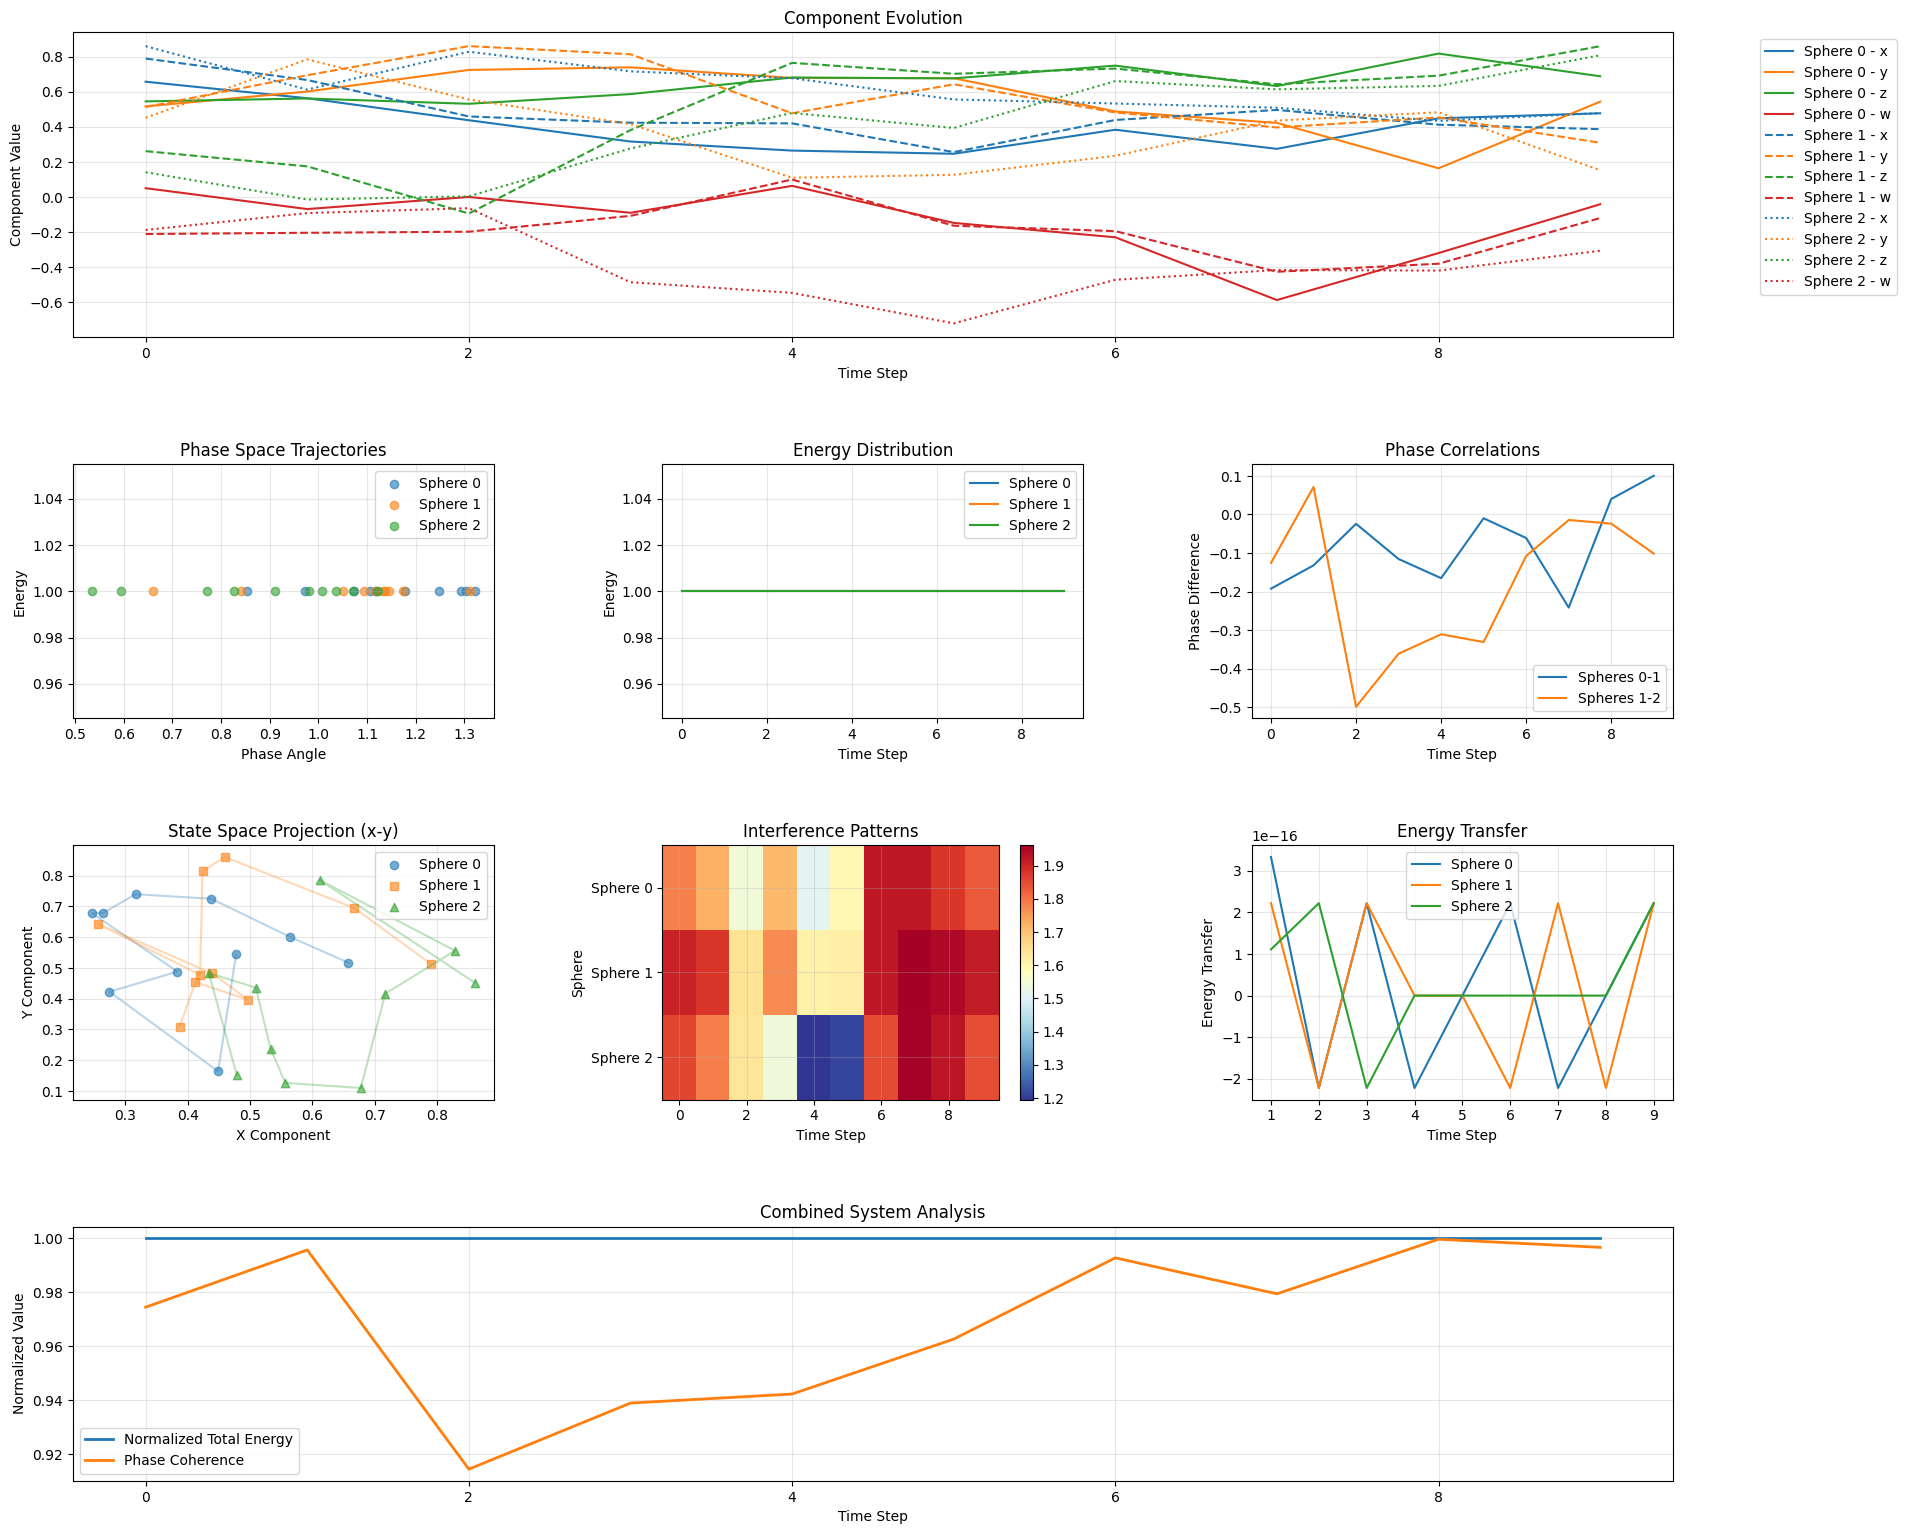

In [3]:
# Create model and analyzer
model = MultiSphereWaveModel(M=3, reflection=0.2, transmission=0.7, noise_std=0.05)
analyzer = WaveMemoryAnalyzer()

# Run analysis
fig, history, metrics = analyzer.analyze_model(model, steps=10)
plt.show()


Testing configuration: 3 spheres x 1 layers
Computation time: 0.0066s
Average interference: 26.5351
Average energy stability: 1.0000
Average phase coherence: 0.9721

Testing configuration: 5 spheres x 1 layers
Computation time: 0.0063s
Average interference: 63.7087
Average energy stability: 1.0000
Average phase coherence: 0.9564

Testing configuration: 10 spheres x 1 layers
Computation time: 0.0134s
Average interference: 344.1971
Average energy stability: 1.0000
Average phase coherence: 0.9404

Testing configuration: 20 spheres x 1 layers
Computation time: 0.0265s
Average interference: 1122.0466
Average energy stability: 1.0000
Average phase coherence: 0.9400

Testing configuration: 40 spheres x 1 layers
Computation time: 0.0526s
Average interference: 4263.8923
Average energy stability: 1.0000
Average phase coherence: 0.8880

Testing configuration: 100 spheres x 1 layers
Computation time: 0.1247s
Average interference: 25206.2018
Average energy stability: 1.0000
Average phase coherence

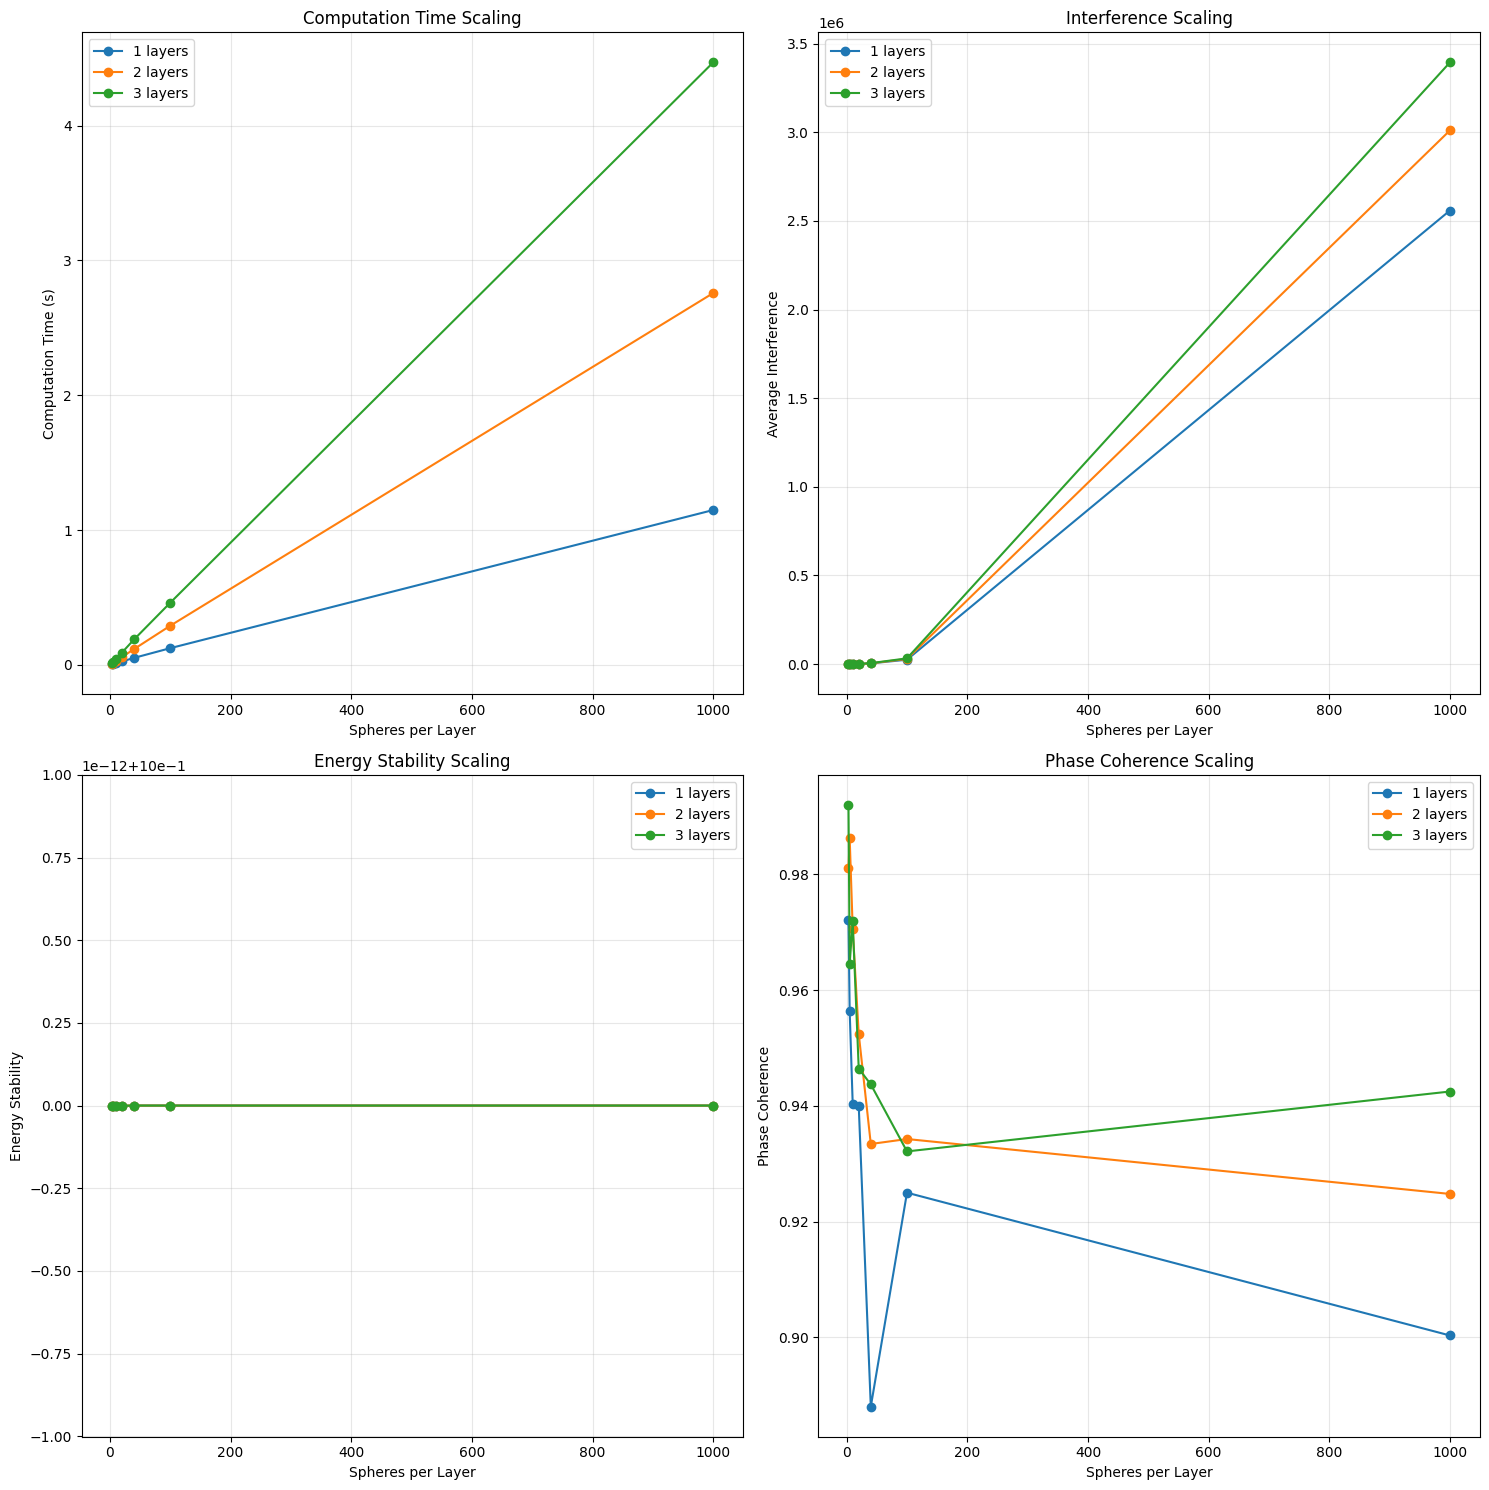

In [4]:
import numpy as np
import time
from dataclasses import dataclass
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

@dataclass
class LayerConfig:
    """Configuration for a single layer"""
    num_spheres: int
    reflection: float = 0.2
    transmission: float = 0.7
    noise_std: float = 0.05

@dataclass
class ScalingResults:
    """Results from scaling analysis"""
    layer_configs: List[LayerConfig]
    computation_time: float
    total_interference: float
    energy_stability: float
    phase_coherence: float

class MultiLayerWaveSystem:
    """System for managing multiple layers of wave spheres"""
    
    def __init__(self, layer_configs: List[LayerConfig]):
        self.layer_configs = layer_configs
        self.layers = []
        self.histories = []  # Store histories for each layer
        
        # Initialize layers
        for config in layer_configs:
            layer = MultiSphereWaveModel(
                M=config.num_spheres,
                reflection=config.reflection,
                transmission=config.transmission,
                noise_std=config.noise_std
            )
            self.layers.append(layer)
            
        # Initialize states
        self._initialize_states()
    
    def _initialize_states(self):
        """Initialize states for all layers"""
        for layer_idx, layer in enumerate(self.layers):
            num_spheres = self.layer_configs[layer_idx].num_spheres
            for sphere_idx in range(num_spheres):
                # Distribute initial vectors evenly around the hypersphere
                angle = (2 * np.pi * sphere_idx) / num_spheres
                fast_vec = [np.cos(angle), np.sin(angle), 0, 0]
                layer.set_initial_state(sphere_idx, fast_vec=fast_vec)
    
    def step(self, input_waves: List[np.ndarray] = None) -> List[np.ndarray]:
        """Perform one step through all layers"""
        layer_outputs = []
        current_input = input_waves
        
        for layer_idx, layer in enumerate(self.layers):
            # Process layer
            if layer_idx == 0 and input_waves is not None:
                # First layer gets external input
                outputs = layer.step(current_input)
            else:
                # Other layers get input from previous layer
                num_spheres = self.layer_configs[layer_idx].num_spheres
                if current_input is None:
                    current_input = [None] * num_spheres
                outputs = layer.step(current_input)
            
            layer_outputs.append(outputs)
            current_input = outputs  # Output becomes input for next layer
            
        return layer_outputs
    
    def run(self, steps: int = 10, input_sequence: List[List[np.ndarray]] = None) -> List[List[np.ndarray]]:
        """Run the system for multiple steps"""
        histories = [[] for _ in self.layers]  # Separate history for each layer
        
        for t in range(steps):
            input_waves = None if input_sequence is None else input_sequence[t]
            layer_outputs = self.step(input_waves)
            
            for layer_idx, outputs in enumerate(layer_outputs):
                histories[layer_idx].append(outputs)
        
        self.histories = [np.array(h) for h in histories]
        return self.histories

def run_scaling_analysis(sphere_counts: List[int], num_layers: List[int], steps: int = 10) -> Dict[Tuple[int, int], ScalingResults]:
    """Run scaling analysis for different configurations"""
    results = {}
    
    for num_layer in num_layers:
        for spheres_per_layer in sphere_counts:
            print(f"\nTesting configuration: {spheres_per_layer} spheres x {num_layer} layers")
            
            # Create layer configurations
            layer_configs = [
                LayerConfig(num_spheres=spheres_per_layer)
                for _ in range(num_layer)
            ]
            
            # Create and time system
            start_time = time.perf_counter()
            
            system = MultiLayerWaveSystem(layer_configs)
            
            # Create input sequence for first layer
            input_sequence = []
            for t in range(steps):
                if t < 5:
                    waves = [np.array([0.0, 0.5, 0.5, 0.0])] + [None] * (spheres_per_layer - 1)
                else:
                    waves = [None] * spheres_per_layer
                input_sequence.append(waves)
            
            # Run system
            histories = system.run(steps=steps, input_sequence=input_sequence)
            
            computation_time = time.perf_counter() - start_time
            
            # Calculate metrics
            total_interference = 0
            energy_stability = 0
            phase_coherence = 0
            
            for layer_idx, history in enumerate(histories):
                # Interference
                for t in range(steps):
                    for i in range(spheres_per_layer):
                        for j in range(i + 1, spheres_per_layer):
                            total_interference += abs(np.dot(history[t, i], history[t, j]))
                
                # Energy stability
                energies = [sum(np.sum(state**2) for state in states) for states in history]
                energy_stability += 1.0 / (1.0 + np.std(energies))
                
                # Phase coherence
                coherence = []
                for states in history:
                    phases = [np.arctan2(np.linalg.norm(state[1:]), state[0]) for state in states]
                    diffs = [abs(p1 - p2) for i, p1 in enumerate(phases) for p2 in phases[i+1:]]
                    if diffs:
                        coherence.append(np.mean(np.cos(diffs)))
                phase_coherence += np.mean(coherence) if coherence else 0
            
            # Average metrics across layers
            total_interference /= num_layer
            energy_stability /= num_layer
            phase_coherence /= num_layer
            
            results[(spheres_per_layer, num_layer)] = ScalingResults(
                layer_configs=layer_configs,
                computation_time=computation_time,
                total_interference=total_interference,
                energy_stability=energy_stability,
                phase_coherence=phase_coherence
            )
            
            print(f"Computation time: {computation_time:.4f}s")
            print(f"Average interference: {total_interference:.4f}")
            print(f"Average energy stability: {energy_stability:.4f}")
            print(f"Average phase coherence: {phase_coherence:.4f}")
    
    return results

def plot_scaling_results(results: Dict[Tuple[int, int], ScalingResults]):
    """Plot scaling analysis results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    sphere_counts = sorted(set(k[0] for k in results.keys()))
    layer_counts = sorted(set(k[1] for k in results.keys()))
    
    # Plot computation time scaling
    ax = axes[0, 0]
    for num_layers in layer_counts:
        times = [results[(s, num_layers)].computation_time for s in sphere_counts]
        ax.plot(sphere_counts, times, 'o-', label=f'{num_layers} layers')
    ax.set_xlabel('Spheres per Layer')
    ax.set_ylabel('Computation Time (s)')
    ax.set_title('Computation Time Scaling')
    ax.legend()
    ax.grid(True)
    
    # Plot interference scaling
    ax = axes[0, 1]
    for num_layers in layer_counts:
        interf = [results[(s, num_layers)].total_interference for s in sphere_counts]
        ax.plot(sphere_counts, interf, 'o-', label=f'{num_layers} layers')
    ax.set_xlabel('Spheres per Layer')
    ax.set_ylabel('Average Interference')
    ax.set_title('Interference Scaling')
    ax.legend()
    ax.grid(True)
    
    # Plot energy stability
    ax = axes[1, 0]
    for num_layers in layer_counts:
        stab = [results[(s, num_layers)].energy_stability for s in sphere_counts]
        ax.plot(sphere_counts, stab, 'o-', label=f'{num_layers} layers')
    ax.set_xlabel('Spheres per Layer')
    ax.set_ylabel('Energy Stability')
    ax.set_title('Energy Stability Scaling')
    ax.legend()
    ax.grid(True)
    
    # Plot phase coherence
    ax = axes[1, 1]
    for num_layers in layer_counts:
        coh = [results[(s, num_layers)].phase_coherence for s in sphere_counts]
        ax.plot(sphere_counts, coh, 'o-', label=f'{num_layers} layers')
    ax.set_xlabel('Spheres per Layer')
    ax.set_ylabel('Phase Coherence')
    ax.set_title('Phase Coherence Scaling')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Test with different configurations
    sphere_counts = [3, 5, 10, 20,40,100,1000]  # Spheres per layer
    layer_counts = [1, 2, 3]        # Number of layers
    
    # Run scaling analysis
    results = run_scaling_analysis(sphere_counts, layer_counts)
    
    # Plot results
    plot_scaling_results(results)
